# Background-Foreground Detection
## Gustavo Efeiche

Neste relatório o objetivo foi realizar uma contagem de pessoas utilizando o algoritmo proposto por Kyungnam Kima, Thanarat H. Chalidabhongseb, David Harwooda, e Larry Davisa no artigo "Real-time foreground–background segmentation using codebook model". O artigo trabalha com a ideia de _codebooks_, um conjunto de informações a respeito de um pixel em uma sequência temporal. 

O algoritmo é simples: para cada pixel de cada imagem, gero um vetor de informações a respeito deste pixel. Caso este vetor seja semelhante a um anterior, a frequência do anterior é incrementada. Caso não seja semelhante, um novo vetor é criado com as respectivas informações. No final, as informações com maior frequência se torna o "plano de fundo", pois aparece muitas vezes ao longo do tempo, e as informações com menor freqûencia se tornam o "plano principal", pois aparecem menos vezes, se destacando mais. O processo detalhado e o algoritmo estão explicados abaixo.

In [2]:
import pickle
import timeit
from datetime import timedelta
from os import listdir, environ
from os.path import abspath, dirname, join
from random import choice, shuffle
from sys import argv

import cv2
import matplotlib.pyplot as plt
import numpy as np

### Parâmetros

|Nome|Descrição|
|----|---------|
|EPSILON_1|Threshold para a função `color distortion` de treinamento|
|EPSILON_2|Threshold para a função `color distortion` de teste|
|ALPHA|Hiperparâmetro utilizado para calcular o range aceitável de brilho de um pixel|
|BETA|Hiperparâmetro utilizado para calcular o range aceitável de brilho de um pixel|
|N_IMAGES|Quantidade de imagens aleatórias a serem utilizadas para o treinamento|

In [3]:
EPSILON_1  = 12
EPSILON_2  = 8
ALPHA      = 0.4
BETA       = 1.1
N_IMAGES   = 20

### Funções de auxílio

`random_image()`: esta função gera uma lista de caminhos para imagens aleatórias a serem utilizadas no treinamento do modelo. Utiliza a pasta images que acompanha o Notebook.

In [4]:
def random_images(n=10, d="BG", v=1):
    """Generates a list of paths to random images.

    The images are located in the ìmages/ directory, divided in 3 datasets:
        - BG (Background): images intended for training
        - CC (City Center): images with fewer people
        - L1 (Large Group): images with more people

    Each section contains pictures of up to 4 cameras with different angles,
    taken at several moments of the day.

    Args:
        n: number of random images to gather
        d: dataset ("BG", "CC" or "L1")
        v: camera (view) to be used

    Returns:
        List of strings representing relative paths to images/ directory

    Raises:
        AssertionError: v must be between 0 (excluded) and 4 (included)
    """
    assert (0 < v <= 4)

    base_path = f"../images/{d}/{v}/"
    timestamps = listdir(base_path) 

    images = []
    for _ in range(n):
        img_dir = join(base_path, choice(timestamps))
        img_path = choice(listdir(img_dir))
        images.append(join(img_dir, img_path))

    return images, d, v

`read_img()`: lê uma imagem de um arquivo, converte para RGB e para _double_.

In [5]:
def read_img(file):
    """Reads image from specific file and creates a Numpy array.

    The picture must be converted to RGB because OpenCV defaults to BGR.
    Pixel data is converted to double for calculation sake.

    Args:
        file: string containing path to image

    Returns:
        RGB image with pixel data as double
    """
    i = cv2.cvtColor(
        cv2.imread(file),
        cv2.COLOR_BGR2RGB
    ).astype(float)

    return i

`count_cw()`: conta quantos codewords existem no modelo

In [6]:
def count_cw(codebooks):
    """Counts codewords in model.
    """
    return sum([len(i) for i in codebooks])

### Funções do Codeword

`brightness()`: checa se o brilho do pixel se encontra dentro de um _range_ específico

In [7]:
def brightness(I, Imin, Imax, alpha, beta):
    """Detect if pixel brightness is inside brightness range.

    Args:
        I: pixel brightness
        Imin: min allowed brightness
        Imax: max allowed brightness
        alpha: hyperparameter
        beta: hyperparameter

    Returns:
        True if brightness is inside range.
        False otherwise.
    """
    return alpha*Imax <= I <= min(beta*Imax, Imin/alpha)

`colordist()`: verifica a distorção (diferença) de cor entre dois pixels

In [8]:
def colordist(X, V):
    """Calculates color distortion between to pixels

    If the pixel is black, pixel module will be zero, causing a
    FloatingPointError in the calculation. Thus, if module is zero,
    p_squared is zeroed automatically.

    Args:
        X, V: rgb arrays representing one pixel each

    Returns:
        Color distortion 
    """
    mod_X = sum([i**2 for i in X])
    mod_V = sum([i**2 for i in V])
    inner_prod_squared = sum([X[i]*V[i] for i in range(len(V))])**2
    
    if mod_V == 0.0:
        p_squared = 0.0
    else:
        p_squared = inner_prod_squared / mod_V
    
    return abs(mod_X - p_squared)**0.5

`create_codeword()`: cria um codeword de acordo com a seção 2 do artigo

In [9]:
def create_codeword(cb, rgb, I, t):
    """Creates new codeword.

    Args:
        cb: codebooks array
        rgb: pixel vector
        I: pixel brightness
        t: current iteration

    """
    cw = list(rgb) + [I, I, 1, t-1, t, t]
    cb.append(cw)

`update_codeword()`: atualiza um codeword de acordo com a seção 2 do artigo

In [10]:
def update_codeword(cw, rgb, I, t):
    """Update codeword with new values.

    Args:
        cw: codeword
        rgb: pixel vector
        I: pixel brightness
        t: current iteration
    """
    cw[0] = (cw[5] * cw[0] + rgb[0]) / (cw[5] + 1)
    cw[1] = (cw[5] * cw[1] + rgb[1]) / (cw[5] + 1)
    cw[2] = (cw[5] * cw[2] + rgb[2]) / (cw[5] + 1)
    cw[3] = min(I, cw[3])
    cw[4] = max(I, cw[4])
    cw[5] += 1
    cw[6] = max(cw[6], t - cw[8])
    cw[8] = t

`match()`: verifica se um pixel e uma codeword possuem semelhanças

In [11]:
def match(X, V, I, Imin, Imax, alpha, beta, epsilon):
    """Checks if two pixels matched based on colordist and brightness.

    Args:
        (Explained above)

    Returns:
        True if matched.
        False otherwise.
    """
    return colordist(X, V) < epsilon and brightness(I, Imin, Imax, alpha, beta)

`train()`: fase de treinamento do modelo

Alguns conceitos devem ser esclarecidos antes de partirmos para o algoritmo:

- Codeword: um vetor contendo os níveis RGB do pixel que compões, brilho mínimo, brilho máximo, frequência, MNRL, observação inicial e observação final daquele codeword. Estes parâmetros estão melhor explicados no artigo.

- Codebook: conjunto de codewords para um pixel.

Todas as imagens tem o mesmo tamanho, portanto, considerando a imagem como uma matriz, as posições i,j serão as mesmas em todas as amostras. Há também uma matriz de codebooks, de mesma dimensão das imagens, que será utilizado para atualizar os codewords de cada pixel.

Em cada iteração, uma imagem será aberta e seus pixels serão comparados ao vetor de codebooks. Para cada pixel existe um codebook, com pelo menos uma codeword. Nesta iteração, o pixel será comparado às codewords do codebook na mesma posição i,j para verificar um "match" (detalhado mais acima). Caso um match aconteça com uma codeword, essa codeword será atualizada com as informações do novo pixel. Caso não haja um match, uma nova codeword será criada para aquele pixel. Isso se repete para todas as imagens, atualizando sempre **o mesmo** vetor de codebooks. No final de todas as iterações, os lambdas (MNRL) de cada codeword são atualizados e as codewords menos frequentes são removidas do modelo. Assim, as codewords mais frequentes se tornam o plano de fundo e, quando uma outra imagem for usada para testar o modelo, apresentará informação "nova", se destacando em relação ao plano de fundo. 

In [12]:
def train(imgs):
    
    # Iterate over N images
    for t, file in enumerate(images, start=1):

        img = read_img(file)

        # If it is the first iteration, create the codebooks
        if t == 1:
            n_codebooks = img.shape[0] * img.shape[1]
            codebooks = [[] for _ in range(n_codebooks)]

        start_time = timeit.default_timer()

        # For each pixel (codebook)
        idx = -1
        for px in np.ndindex(img.shape[:2]):
            idx += 1

            # Calculate pixel brightness
            I = (img[px][0]**2 + img[px][1]**2 + img[px][2]**2)**0.5

            codebook_empty = True
            no_match = True

            # For each codeword inside the current codebook
            for cw in codebooks[idx]:
                codebook_empty = False

                # If pixel in current image matched with existing codeword
                # based on colordist and brightness
                if match(img[px], cw[0:3], I, cw[3], cw[4],
                        ALPHA, BETA, EPSILON_1):

                    # Update codeword as in Section 2 of the article
                    update_codeword(cw, img[px], I, t)
                    
                    no_match = False

                    break

            # If there are no codewords in current codebook or there is no
            # matching codeword, create a new codeword with current pixel info
            if codebook_empty or no_match:
                create_codeword(codebooks[idx], img[px], I, t)

        # Verbose
        number_fill = len(str(len(images)))
        filename = "/".join(file.split("/")[-2:])
        print(f"- IMG {t:0{number_fill+1}d} ({filename}) took ", end="")
        print(f"{timeit.default_timer() - start_time:.3f} seconds")

    # Update maximum negative run-length
    print("\nUPDATING LAMBDAS")
    for codebook in codebooks:
        for codeword in codebook:
            codeword[6] = max(codeword[6], (len(images)-codeword[8]+codeword[7]-1))

    for codebook in codebooks:
        for codeword in codebook:
            if codeword[6] > N_IMAGES / 2:
                # I can't delete right after finding because it would mess
                # up the for loop
                codeword = None

        codebook = [cw for cw in codebook if cw is not None]


    print(f"Codewords: {count_cw(codebooks)} (~{count_cw(codebooks)/n_codebooks:.2f}/codebook)")

    print("\nSAVING TRAINING DATA TO train.pickle\n")
    with open('train.pickle', 'wb') as f:
        pickle.dump(codebooks, f, protocol=pickle.HIGHEST_PROTOCOL)

`subtraction()`: separa o background do foreground de uma imagem

Com o modelo treinado, podemos utilizar outras imagens para testar o modelo. No momento do treinamento, é bom utilizarmos imagens com o menor número de pessoas possíveis, para que o teste se saia melhor. No momento do teste é feito o seguinte cálculo: para cada pixel da imagem, se o pixel tiver um match com um codeword do codebook correspondente, significa que o pixel é "comum" (já aṕareceu antes), então é plano de fundo e será pintado de preto. Caso não haja o match, aquela informação do pixel é "nova", portanto aquele pixel pertence ao primeiro plano e será pintado de branco. Assim, se o treinamento for bem feito, no final teremos uma imagem em que pessoas estão pintadas de branco e o resto pintado de preto. 

In [13]:
def subtraction(codebooks, img):
    bw_img = np.copy(img)

    idx = -1
    for px in np.ndindex(img.shape[:2]):
        idx += 1

        I = (img[px][0]**2 + img[px][1]**2 + img[px][2]**2)**0.5

        for cw in codebooks[idx]:

            if match(img[px], cw[0:3], I, cw[3], cw[4], ALPHA, BETA, EPSILON_2):
                update_codeword(cw, img[px], I, 1)
                bw_img[px] = [0, 0, 0]
                break

            bw_img[px] = [255, 255, 255]

    return bw_img, img

`count_people()`: conta quantas pessoas existem na imagem

A partir da imagem obtida no passo de subtração (teste), podemos realizar a contagem de pessoas. Para realizar esta tarefa, este código utiliza a detecção de *blobs* (manchas) na imagem. Como o plano de fundo é preto e as pessoas estão pintadas de branco, fica fácil detectar manchas. Aqui estamos usando o SimpleBlobDetector do OpenCV. O funcionamento é simples: primeiro realizamos uma erosão e dilatação na imagem, para que as manchas fiquem mais ressaltadas. Em seguida, detectamos pontos chave (keypoints) na imagem, que, neste caso, serão as pessoas. Caso o treinamento esteja correto, um keypoint será detectado para cada pessoa. O funcionamento detalhado do SimpleBlobDetector não será explicado aqui, mas pode ser estudado em https://docs.opencv.org/3.4/d0/d7a/classcv_1_1SimpleBlobDetector.html

In [14]:
def count_people(subtracted, original):
    # https://www.learnopencv.com/blob-detection-using-opencv-python-c/
    # https://makehardware.com/2016/05/19/blob-detection-with-python-and-opencv/
    k = np.ones((10, 10), dtype=np.uint8)
    eroded = cv2.erode(subtracted, k, iterations=1)
    dilated = cv2.dilate(eroded, k, iterations=1)
    
    plt.imshow(dilated)
    plt.show()

    detector_params = cv2.SimpleBlobDetector_Params()
    detector_params.filterByInertia = False
    detector_params.filterByConvexity = False
    detector_params.filterByArea = True
    detector_params.minArea = 400

    detector = cv2.SimpleBlobDetector_create(detector_params)
    rev = 255 - np.uint8(dilated)
    
    keypoints = detector.detect(rev)
    
    im_with_keypoints = cv2.drawKeypoints(
        np.uint8(original),
        keypoints,
        np.array([]),
        (255,0,0),
        cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    plt.imshow(im_with_keypoints)
    plt.show()

    return len(keypoints)

## Treinar

In [15]:
images, d, v = random_images(N_IMAGES)
print(f"\nTRAINING ({d}/View {v})")
train(images)


TRAINING (BG/View 1)
- IMG 001 (13-32/00000031.jpg) took 1.926 seconds
- IMG 002 (13-38/00000242.jpg) took 5.738 seconds
- IMG 003 (13-38/00000302.jpg) took 5.964 seconds
- IMG 004 (13-19/00000242.jpg) took 5.471 seconds
- IMG 005 (13-38/00000068.jpg) took 8.493 seconds
- IMG 006 (13-38/00000279.jpg) took 5.954 seconds
- IMG 007 (13-38/00000090.jpg) took 10.982 seconds
- IMG 008 (13-06/00000186.jpg) took 9.927 seconds
- IMG 009 (13-38/00000399.jpg) took 11.621 seconds
- IMG 010 (13-19/00000209.jpg) took 9.371 seconds
- IMG 011 (13-06/00000300.jpg) took 10.969 seconds
- IMG 012 (13-06/00000151.jpg) took 11.547 seconds
- IMG 013 (13-06/00000290.jpg) took 11.863 seconds
- IMG 014 (13-06/00000114.jpg) took 15.184 seconds
- IMG 015 (13-06/00000265.jpg) took 16.780 seconds
- IMG 016 (13-38/00000337.jpg) took 6.729 seconds
- IMG 017 (13-38/00000429.jpg) took 12.296 seconds
- IMG 018 (13-06/00000366.jpg) took 14.204 seconds
- IMG 019 (13-38/00000360.jpg) took 9.381 seconds
- IMG 020 (13-06/00

## Testar

TESTING


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


- IMG (../images/BG/1/13-19/00000181.jpg) took 13.103 seconds


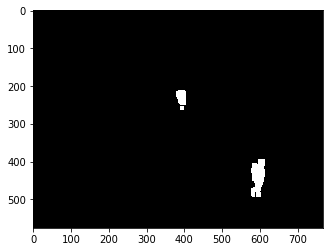

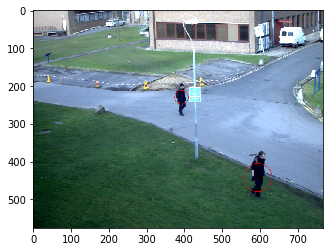

People count: 2


In [17]:
TEST_IMAGE = "../images/BG/1/13-19/00000181.jpg"

if TEST_IMAGE is None:
    exit("No test image!")

with open("train.pickle", "rb") as f:
    codebooks = pickle.load(f)

print("TESTING")
img = read_img(TEST_IMAGE)

start_time = timeit.default_timer()

subtracted, original = subtraction(codebooks, img)

print(f"- IMG ({TEST_IMAGE}) took {timeit.default_timer() - start_time:.3f} seconds")

n_people = count_people(subtracted, original)

print(f"People count: {n_people}")